In [5]:
import json
import sys
from mrtparse import *
import networkx as nx
import matplotlib.pyplot as plt

import os
import requests
import gzip
import shutil
import openai

from neo4j import GraphDatabase


In [6]:
server_url = "https://data.ris.ripe.net"
rrc_name = "rrc00"
year = "2017"
month = "09"
date = "01"
time = "0800"

zip_file_name = "bview.{}{}{}.{}.gz".format(year,month,date,time)
filename = "bview.{}{}{}.{}".format(year,month,date,time)

remote_url = server_url + "/" + rrc_name + "/" + year + "." + month + "/" + zip_file_name
print(remote_url)

https://data.ris.ripe.net/rrc00/2017.09/bview.20170901.0800.gz


In [7]:
r = requests.get(remote_url, allow_redirects=True)

if(r.status_code==200):

    ## Removing the zip file if it exists
    if os.path.isfile(zip_file_name):
        os.remove(zip_file_name)

    ## Removing content file if it exists
    if os.path.isfile(filename):
        os.remove(filename)

    ## Obtaining the zip file
    with open(zip_file_name, 'wb') as f:
        f.write(r.content)

    ## Obtaining the content file
    with gzip.open(zip_file_name, 'rb') as f_in:
        with open(filename, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

    ## Removing the zip file after extraction
    if os.path.isfile(zip_file_name):
        os.remove(zip_file_name)
else:
    print('File does not exist')

In [8]:
#edge_connections = ""

G = nx.DiGraph()
node_check = []

i = 0
for entry in Reader(filename):

    curr_json = entry.data
    #check_json.append(curr_json)

    if list(curr_json['subtype'].values())[0]== "RIB_IPV4_UNICAST":

        if 'rib_entries' in curr_json.keys():

            entry_count = curr_json.get('entry_count',0)
            for j in range(entry_count):
                curr_list = curr_json['rib_entries'][j]['path_attributes'][1]['value'][0]['value']
                #check_list.append(curr_list)

                N = len(curr_list)
                for k in range(N-1):
                    if(curr_list[k+1]!=curr_list[k]): ## Avoiding same node cycles
                        G.add_edge(curr_list[k+1],curr_list[k])
                        node_check.append(curr_list[k+1])
                        node_check.append(curr_list[k])
        else:
            curr_list = curr_json['path_attributes'][1]['value'][0]['value']
            #check_list.append(curr_list)

            N = len(curr_list)
            for k in range(N-1):
                if(curr_list[k+1]!=curr_list[k]):
                    G.add_edge(curr_list[k+1],curr_list[k])
                    node_check.append(curr_list[k+1])
                    node_check.append(curr_list[k])


        i += 1

    if(i==20):
        break

#print(len(list(set(node_check))))

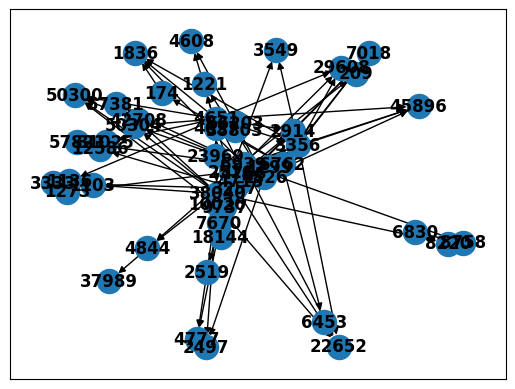

In [9]:
nx.draw_networkx(G, with_labels=True, font_weight='bold')

In [10]:
formatted_string = ""
connect_list = []
node_list = []

i = 0
for entry in Reader(filename):

    curr_json = entry.data
    #check_json.append(curr_json)

    if list(curr_json['subtype'].values())[0]== "RIB_IPV4_UNICAST":

        if 'rib_entries' in curr_json.keys():

            entry_count = curr_json.get('entry_count',0)
            for j in range(entry_count):
                curr_list = curr_json['rib_entries'][j]['path_attributes'][1]['value'][0]['value']
                #check_list.append(curr_list)

                N = len(curr_list)
                for k in range(N-1):
                    if(curr_list[k+1]!=curr_list[k]): ## Avoiding same node cycles
                        connect_list.append('An arc exists strating from ' + curr_list[k+1] + " into " + curr_list[k])
                        node_list.append(curr_list[k+1])
                        node_list.append(curr_list[k])
        else:
            curr_list = curr_json['path_attributes'][1]['value'][0]['value']
            #check_list.append(curr_list)

            N = len(curr_list)
            for k in range(N-1):
                if(curr_list[k+1]!=curr_list[k]):
                    connect_list.append('An arc exists starting from ' + curr_list[k+1] + " into " + curr_list[k])
                    node_list.append(curr_list[k+1])
                    node_list.append(curr_list[k])


        i += 1

    if(i==20):
        break

connect_list = list(set(connect_list))
node_list = list(set(node_list))
formatted_string = "\n".join(connect_list)
formatted_string_nodes = ",".join(node_list)
#print(formatted_string)

## OpenAI Setup

In [11]:
import os
name = 'OPENAI_API_KEY'

key_location = "./key.txt"
key_file = open(key_location, "r")
openapi_key = key_file.readline()

#secret = getpass.getpass("Enter the OpenAI API Key")
os.environ[name] = openapi_key
print(f"Have successfully set up {name} as an environment variable.")

Have successfully set up OPENAI_API_KEY as an environment variable.


In [12]:
# Define your API key (keep it secret!)
openai.api_key = openapi_key
API_KEY = openapi_key

## Creating examples

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

import random
import pickle

In [14]:

node_list = [i for i in range(5, 36)] ## List of possible number of nodes
no_of_graphs = 150 ## Number of graphs to be generated
graph_list = []

for i in range(no_of_graphs):
    curr_node_number = random.choice(node_list)
        
    prob_edge = 0.2 # Probability of edge creation (Increase it if you want more edges)
    curr_G = nx.fast_gnp_random_graph(n=curr_node_number,
                             p=prob_edge,
                             directed=True,
                             seed=123)
    graph_list.append(curr_G)


In [15]:
curr_file_name = "example_graphs_file.pkl"

with open(curr_file_name, 'wb') as f:
    pickle.dump(graph_list, f)

In [16]:
curr_file_name = "example_graphs_file.pkl"

with open(curr_file_name, 'rb') as f:
    graph_list = pickle.load(f)

In [17]:
## Describing a graph

def describe_graph(curr_graph,curr_num):
    
    """
    Function to describe a graph with nodes and edges
    
    input:
    curr_graph : A graph object
    curr_num : Integer to describe the graph
    
    output:
    graph_desc: A string object with description about the graph
    """
    
    
    graph_desc = """"""

    nodes = list(curr_graph.nodes())
    edges = list(curr_graph.edges())

    nodes = [str(each_node) for each_node in nodes]
    edges = [('An arc exists starting from ' + str(curr_edge[0]) + " into " + str(curr_edge[1])) for curr_edge in edges]

    graph_desc = graph_desc + """
    Graph {} has nodes {}
    and the edges are described as follows

    {}
    """.format(str(curr_num),','.join(nodes),'\n  '.join(edges))

    return graph_desc

In [18]:
def describe_indegree(curr_graph):

    indegree_desc = """ 
    The indegree of the nodes are as follows 
    """

    nodes = list(curr_graph.nodes())
    edges = list(curr_graph.edges())

    nodes_str = [str(each_node) for each_node in nodes]

    for k in range(len(nodes)):

        curr_node_str = nodes_str[k]
        curr_node = nodes[k]

        curr_indegree = curr_graph.in_degree(curr_node)

        indegree_desc = indegree_desc + """
        In degree of node {} is {}""".format(curr_node_str, str(curr_indegree))
    
    return indegree_desc

In [19]:
def describe_outdegree(curr_graph):

    indegree_desc = """ 
    The outdegree of the nodes are as follows 
    """

    nodes = list(curr_graph.nodes())
    edges = list(curr_graph.edges())

    nodes_str = [str(each_node) for each_node in nodes]

    for k in range(len(nodes)):

        curr_node_str = nodes_str[k]
        curr_node = nodes[k]

        curr_indegree = curr_graph.out_degree(curr_node)

        indegree_desc = indegree_desc + """
        Out degree of node {} is {}""".format(curr_node_str, str(curr_indegree))
    
    return indegree_desc

In [20]:
def get_nodes_from_description(curr_graph):
    lines = curr_graph.strip().split('\n')
    first_line = lines[0]
    nodes_part = first_line.split('nodes')[1]
    # We remove any leading or trailing spaces and split the string by commas to get the individual nodes
    nodes = nodes_part.strip().split(',')
    # The number of nodes is simply the length of this list
    number_of_nodes = len(nodes)

    return number_of_nodes


In [21]:
describe_indegree(graph_list[0])

' \n    The indegree of the nodes are as follows \n    \n        In degree of node 0 is 3\n        In degree of node 1 is 2\n        In degree of node 2 is 2\n        In degree of node 3 is 4\n        In degree of node 4 is 0\n        In degree of node 5 is 0\n        In degree of node 6 is 2'

In [22]:

## To generate prompts for indegree

graph_node_prompt = []
graph_node_ans = []
graph_indegree_ans = []

i = 0

for each_graph in graph_list:
    graph_node_prompt.append(describe_graph(each_graph,i))
    graph_node_ans.append(get_nodes_from_description(describe_graph(each_graph,i)))
    graph_indegree_ans.append(describe_indegree(each_graph))

    i+=1
    
print(graph_node_prompt[1])
print("Nodes: ", graph_node_ans[1])
print(graph_indegree_ans[1])


    Graph 1 has nodes 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
    and the edges are described as follows

    An arc exists starting from 0 into 1
  An arc exists starting from 0 into 2
  An arc exists starting from 0 into 7
  An arc exists starting from 0 into 11
  An arc exists starting from 0 into 12
  An arc exists starting from 0 into 14
  An arc exists starting from 0 into 22
  An arc exists starting from 0 into 25
  An arc exists starting from 0 into 26
  An arc exists starting from 0 into 27
  An arc exists starting from 0 into 28
  An arc exists starting from 0 into 31
  An arc exists starting from 1 into 3
  An arc exists starting from 1 into 6
  An arc exists starting from 1 into 9
  An arc exists starting from 1 into 12
  An arc exists starting from 1 into 16
  An arc exists starting from 1 into 18
  An arc exists starting from 1 into 20
  An arc exists starting from 1 into 26
  An arc exists starting from 1 into 30
  An arc

In [23]:
import json
import random

def generate_finetuning_json(graph_node_prompt, graph_node_ans, graph_indegree_ans, system_content, train_file='train_messages.json', test_file='test_messages.json', train_prob=0.7):
    """
    Generates two JSON files, one for training and one for testing, with provided data.

    :param graph_node_prompt: List of prompts regarding the number of nodes
    :param graph_node_ans: List of answers regarding the number of nodes
    :param graph_indegree_ans: List of answers regarding the indegree of nodes
    :param system_content: Content to be used by the system role
    :param train_file: Filename for the training JSON file
    :param test_file: Filename for the testing JSON file
    :param train_prob: Probability that an entry will be included in the training set
    """
    n = len(graph_node_prompt)
    train_data = []
    test_data = []

    for i in range(n):
        user_content_node = graph_node_prompt[i] + "\n" + 'How many nodes are there?'
        assistant_content_node = 'There are ' + str(graph_node_ans[i]) + ' nodes.'

        user_content_indegree = graph_node_prompt[i] + "\n" + 'What is the indegree of all the nodes?'
        assistant_content_indegree = graph_indegree_ans[i]

        message_node = [
            {"role": "system", "content": system_content},
            {"role": "user", "content": user_content_node},
            {"role": "assistant", "content": assistant_content_node}
        ]
        message_indegree = [
            {"role": "system", "content": system_content},
            {"role": "user", "content": user_content_indegree},
            {"role": "assistant", "content": assistant_content_indegree}
        ]

        # Decide whether to put the message in training or testing
        if random.random() < train_prob:
            train_data.append({"messages": message_node})
            train_data.append({"messages": message_indegree})
        else:
            test_data.append({"messages": message_node})
            test_data.append({"messages": message_indegree})

    # Write to train JSON file
    with open(train_file, 'w') as file:
        for entry in train_data:
            json.dump(entry, file)
            file.write('\n')

    # Write to test JSON file
    with open(test_file, 'w') as file:
        for entry in test_data:
            json.dump(entry, file)
            file.write('\n')




In [24]:
system_content = "CDL is a factual graph interpreter that gives information about a graph given its description"
generate_finetuning_json(graph_node_prompt, graph_node_ans, graph_indegree_ans, system_content)

## Data validation

In [25]:
import json
import tiktoken # for token counting
import numpy as np
from collections import defaultdict

data_path = "./train_messages.json"

# Load the dataset
with open(data_path, 'r', encoding='utf-8') as f:
    dataset = [json.loads(line) for line in f]

# Initial dataset stats
print("Num examples:", len(dataset))
print("First example:")
for message in dataset[0]["messages"]:
    print(message)

Num examples: 192
First example:
{'role': 'system', 'content': 'CDL is a factual graph interpreter that gives information about a graph given its description'}
{'role': 'user', 'content': '\n    Graph 0 has nodes 0,1,2,3,4,5,6\n    and the edges are described as follows\n\n    An arc exists starting from 0 into 1\n  An arc exists starting from 0 into 2\n  An arc exists starting from 1 into 3\n  An arc exists starting from 1 into 6\n  An arc exists starting from 2 into 3\n  An arc exists starting from 2 into 6\n  An arc exists starting from 2 into 0\n  An arc exists starting from 5 into 0\n  An arc exists starting from 5 into 1\n  An arc exists starting from 5 into 3\n  An arc exists starting from 6 into 0\n  An arc exists starting from 6 into 2\n  An arc exists starting from 6 into 3\n    \nHow many nodes are there?'}
{'role': 'assistant', 'content': 'There are 7 nodes.'}


In [26]:
# Format error checks
format_errors = defaultdict(int)

for ex in dataset:
    if not isinstance(ex, dict):
        format_errors["data_type"] += 1
        continue
        
    messages = ex.get("messages", None)
    if not messages:
        format_errors["missing_messages_list"] += 1
        continue
        
    for message in messages:
        if "role" not in message or "content" not in message:
            format_errors["message_missing_key"] += 1
        
        if any(k not in ("role", "content", "name", "function_call") for k in message):
            format_errors["message_unrecognized_key"] += 1
        
        if message.get("role", None) not in ("system", "user", "assistant", "function"):
            format_errors["unrecognized_role"] += 1
            
        content = message.get("content", None)
        function_call = message.get("function_call", None)
        
        if (not content and not function_call) or not isinstance(content, str):
            format_errors["missing_content"] += 1
    
    if not any(message.get("role", None) == "assistant" for message in messages):
        format_errors["example_missing_assistant_message"] += 1

if format_errors:
    print("Found errors:")
    for k, v in format_errors.items():
        print(f"{k}: {v}")
else:
    print("No errors found")

No errors found


In [27]:
encoding = tiktoken.get_encoding("cl100k_base")

# not exact!
# simplified from https://github.com/openai/openai-cookbook/blob/main/examples/How_to_count_tokens_with_tiktoken.ipynb
def num_tokens_from_messages(messages, tokens_per_message=3, tokens_per_name=1):
    num_tokens = 0
    for message in messages:
        num_tokens += tokens_per_message
        for key, value in message.items():
            num_tokens += len(encoding.encode(value))
            if key == "name":
                num_tokens += tokens_per_name
    num_tokens += 3
    return num_tokens

def num_assistant_tokens_from_messages(messages):
    num_tokens = 0
    for message in messages:
        if message["role"] == "assistant":
            num_tokens += len(encoding.encode(message["content"]))
    return num_tokens

def print_distribution(values, name):
    print(f"\n#### Distribution of {name}:")
    print(f"min / max: {min(values)}, {max(values)}")
    print(f"mean / median: {np.mean(values)}, {np.median(values)}")
    print(f"p5 / p95: {np.quantile(values, 0.1)}, {np.quantile(values, 0.9)}")

In [28]:
# Warnings and tokens counts
n_missing_system = 0
n_missing_user = 0
n_messages = []
convo_lens = []
assistant_message_lens = []

for ex in dataset:
    messages = ex["messages"]
    if not any(message["role"] == "system" for message in messages):
        n_missing_system += 1
    if not any(message["role"] == "user" for message in messages):
        n_missing_user += 1
    n_messages.append(len(messages))
    convo_lens.append(num_tokens_from_messages(messages))
    assistant_message_lens.append(num_assistant_tokens_from_messages(messages))
    
print("Num examples missing system message:", n_missing_system)
print("Num examples missing user message:", n_missing_user)
print_distribution(n_messages, "num_messages_per_example")
print_distribution(convo_lens, "num_total_tokens_per_example")
print_distribution(assistant_message_lens, "num_assistant_tokens_per_example")
n_too_long = sum(l > 4096 for l in convo_lens)
print(f"\n{n_too_long} examples may be over the 4096 token limit, they will be truncated during fine-tuning")

Num examples missing system message: 0
Num examples missing user message: 0

#### Distribution of num_messages_per_example:
min / max: 3, 3
mean / median: 3.0, 3.0
p5 / p95: 3.0, 3.0

#### Distribution of num_total_tokens_per_example:
min / max: 154, 3488
mean / median: 1297.609375, 1124.5
p5 / p95: 230.0, 2812.500000000001

#### Distribution of num_assistant_tokens_per_example:
min / max: 6, 396
mean / median: 110.421875, 36.0
p5 / p95: 6.0, 316.8000000000001

0 examples may be over the 4096 token limit, they will be truncated during fine-tuning


## Cost estimation

In [29]:
# Pricing and default n_epochs estimate
MAX_TOKENS_PER_EXAMPLE = 4096

TARGET_EPOCHS = 5
MIN_TARGET_EXAMPLES = 100
MAX_TARGET_EXAMPLES = 25000
MIN_DEFAULT_EPOCHS = 1
MAX_DEFAULT_EPOCHS = 25

n_epochs = TARGET_EPOCHS
n_train_examples = len(dataset)
if n_train_examples * TARGET_EPOCHS < MIN_TARGET_EXAMPLES:
    n_epochs = min(MAX_DEFAULT_EPOCHS, MIN_TARGET_EXAMPLES // n_train_examples)
elif n_train_examples * TARGET_EPOCHS > MAX_TARGET_EXAMPLES:
    n_epochs = max(MIN_DEFAULT_EPOCHS, MAX_TARGET_EXAMPLES // n_train_examples)

n_billing_tokens_in_dataset = sum(min(MAX_TOKENS_PER_EXAMPLE, length) for length in convo_lens)
print(f"Dataset has {len(dataset)} datapoints")
print(f"Dataset has ~{n_billing_tokens_in_dataset} tokens that will be charged for during training")
print(f"By default, you'll train for {n_epochs} epochs on this dataset")
print(f"By default, you'll be charged for ~{n_epochs * n_billing_tokens_in_dataset} tokens")
print(f"By default, you'll be charged for ~{(n_epochs * n_billing_tokens_in_dataset)/1000 * 0.008} dollars")

Dataset has 192 datapoints
Dataset has ~249141 tokens that will be charged for during training
By default, you'll train for 5 epochs on this dataset
By default, you'll be charged for ~1245705 tokens
By default, you'll be charged for ~9.96564 dollars


## Fine tuning: Run only if you need to retune. Costs $$$

In [30]:
from openai import OpenAI
client = OpenAI()

# Upload training file
# client.files.create(
#   file=open("train_messages.json", "rb"),
#   purpose="fine-tune"
# )

In [31]:
# Upload testing file
# client.files.create(
#   file=open("test_messages.json", "rb"),
#   purpose="fine-tune"
# )

In [32]:
# Create fine tuned model
# Copy file id


# client.fine_tuning.jobs.create(
#   training_file="file-EFutC4Q3DFISnNIck9ircpaq",
#   validation_file="file-a20CLfIyMC4IZOgCnl6xU5PC", 
#   model="gpt-3.5-turbo",
#   hyperparameters={
#     "n_epochs":5
#   }
# )

In [33]:
# client.fine_tuning.jobs.retrieve("ftjob-JRl51tcKPVl176XcmkcrUWKo")

In [34]:
# client.fine_tuning.jobs.list_events(
#   fine_tuning_job_id="ftjob-JRl51tcKPVl176XcmkcrUWKo", 
#   limit=5
# )

## Use model

In [35]:
node_list = [i for i in range(5, 36)] ## List of possible number of nodes
no_of_graphs = 10 ## Number of graphs to be generated
graph_list_test = []

for i in range(no_of_graphs):
    curr_node_number = random.choice(node_list)
        
    prob_edge = 0.2 # Probability of edge creation (Increase it if you want more edges)
    curr_G = nx.fast_gnp_random_graph(n=curr_node_number,
                             p=prob_edge,
                             directed=True,
                             seed=123)
    graph_list_test.append(curr_G)

graph_node_prompt_test = []
graph_node_ans_test = []
graph_indegree_ans_test = []

i = 0

for each_graph in graph_list_test:
    graph_node_prompt_test.append(describe_graph(each_graph,i))
    graph_node_ans_test.append(get_nodes_from_description(describe_graph(each_graph,i)))
    graph_indegree_ans_test.append(describe_indegree(each_graph))

    i+=1
    
print(graph_node_prompt_test[1])
print("Nodes: ", graph_node_ans_test[1])
print(graph_indegree_ans_test[1])


    Graph 1 has nodes 0,1,2,3,4,5,6,7,8,9,10,11,12
    and the edges are described as follows

    An arc exists starting from 0 into 1
  An arc exists starting from 0 into 2
  An arc exists starting from 0 into 7
  An arc exists starting from 0 into 11
  An arc exists starting from 0 into 12
  An arc exists starting from 1 into 3
  An arc exists starting from 1 into 6
  An arc exists starting from 1 into 9
  An arc exists starting from 1 into 12
  An arc exists starting from 2 into 3
  An arc exists starting from 2 into 6
  An arc exists starting from 2 into 7
  An arc exists starting from 2 into 12
  An arc exists starting from 3 into 9
  An arc exists starting from 3 into 0
  An arc exists starting from 3 into 2
  An arc exists starting from 4 into 8
  An arc exists starting from 4 into 9
  An arc exists starting from 4 into 10
  An arc exists starting from 5 into 8
  An arc exists starting from 5 into 10
  An arc exists starting from 5 into 4
  An arc exists starting from 7 into 8

In [44]:
import openai
from openai import OpenAI

client = OpenAI()

def generate_user_prompt(question, context):
    return f"""
       The question is {question}
       Answer the question by using the provided information:
       {context}
       """

def get_gpt3_response(system_prompt, user_content, context, api_key, model="ft:gpt-3.5-turbo-0613:personal::8JDpuK1i"):
    """
    Send a request to the OpenAI Chat API and get a response from the model.
    
    Args:
        prompt (str): The user's question.
        context (str): Contextual information to be passed to the model.
        api_key (str): Your OpenAI API key.
        model (str): The model version to use, default is "gpt-3.5-turbo".
    
    Returns:
        str: The model's response.
    """
    
    # Create the full prompt by combining the system prompt, context, and the user question
    messages = [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": generate_user_prompt(user_content, context)}        
    ]
    
    # Use the OpenAI Python client to send the request
    response = client.chat.completions.create(
        model=model,
        messages=messages
    )
    
    # Extract the response text and return
    return response.choices[0].message

# Nodes

In [46]:
system_content = "CDL is a factual graph interpreter that gives information about a graph given its description"

for i in range(len(graph_node_prompt_test)):
    context_info = graph_node_prompt_test[i]
    question = 'How many nodes are there?'
    response = get_gpt3_response(system_content, question, context_info, API_KEY)
    print(response)
    print("Truth:", graph_node_ans_test[i])

ChatCompletionMessage(content='There are 7 nodes.', role='assistant', function_call=None, tool_calls=None)
Truth: 7
ChatCompletionMessage(content='There are 13 nodes.', role='assistant', function_call=None, tool_calls=None)
Truth: 13
ChatCompletionMessage(content='There are 23 nodes.', role='assistant', function_call=None, tool_calls=None)
Truth: 23
ChatCompletionMessage(content='There are 20 nodes.', role='assistant', function_call=None, tool_calls=None)
Truth: 20
ChatCompletionMessage(content='There are 27 nodes.', role='assistant', function_call=None, tool_calls=None)
Truth: 27
ChatCompletionMessage(content='There are 21 nodes.', role='assistant', function_call=None, tool_calls=None)
Truth: 21
ChatCompletionMessage(content='There are 15 nodes.', role='assistant', function_call=None, tool_calls=None)
Truth: 15
ChatCompletionMessage(content='There are 34 nodes.', role='assistant', function_call=None, tool_calls=None)
Truth: 34
ChatCompletionMessage(content='There are 19 nodes.', role=

# Indegree

In [49]:
system_content = "CDL is a factual graph interpreter that gives information about a graph given its description"

for i in range(len(graph_node_prompt_test)):
    context_info = graph_node_prompt_test[i]
    question = 'What is the indegree of all the nodes?'
    response = get_gpt3_response(system_content, question, context_info, API_KEY)
    print(f"Graph {i} \n")
    print(response.content)
    print("Truth:", graph_indegree_ans_test[i])

Graph 0 

 
       The indegree of the nodes are as follows 
        
           In degree of node 0 is 3
           In degree of node 1 is 2
           In degree of node 2 is 2
           In degree of node 3 is 4
           In degree of node 4 is 0
           In degree of node 5 is 0
           In degree of node 6 is 2
Truth:  
    The indegree of the nodes are as follows 
    
        In degree of node 0 is 3
        In degree of node 1 is 2
        In degree of node 2 is 2
        In degree of node 3 is 4
        In degree of node 4 is 0
        In degree of node 5 is 0
        In degree of node 6 is 2
Graph 1 

 
       The indegree of the nodes are as follows: 
           In degree of node 0 is 4
           In degree of node 1 is 1
           In degree of node 2 is 4
           In degree of node 3 is 3
           In degree of node 4 is 1
           In degree of node 5 is 2
           In degree of node 6 is 4
           In degree of node 7 is 4
           In degree of node 8 is 3
 